In [ ]:
%cd '/data/ztham/'

/data/ztham


In [ ]:
#imports
import pandas as pd
import math
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from collections.abc import Collection
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# Get the Trained Model

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('LSTM_Sodium_MA_2.h5')

2024-05-27 03:11:42.640925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-27 03:11:42.646794: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-27 03:11:42.646980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-27 03:11:42.647722: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Read Dataset

In [ ]:
df = pd.read_csv("sodium.csv")
print(df.shape)
df.head()

(64691, 2)


,Day,Result
0,1,142.0
1,1,139.0
2,1,131.0
3,1,132.0
4,2,139.0


# Bias Simulation and Splitting of Dataset

In [ ]:
no_bias_total = 300  # Set the amount of result with no bias in a day

def simulation(x, bias):
  if len(x) >= no_bias_total:
    x.iloc[no_bias_total:] *= (1 + bias)
  return x


In [ ]:
# Split into training and testing
# 80% training, 20% testing
mid_day = math.ceil(df['Day'].max()*0.8)

train = df[df['Day'] <= mid_day] # Non-anomalous, using df1
test = df[df['Day'] > mid_day] # Some anomalies is found, using df

print(mid_day, train.shape, test.shape)

73 (51164, 2) (13527, 2)


In [ ]:
test1 = test.copy() #retain original without bias

In [ ]:
print(test.shape)
test.head()

(13527, 2)


,Day,Result
51164,74,136.0
51165,74,137.0
51166,74,137.0
51167,74,148.0
51168,74,142.0


In [ ]:
bias = 0.2 # Adjust as needed
test['Result'] = test.groupby('Day')['Result'].transform(lambda x: simulation(x, bias))
print(mid_day, train.shape, test.shape)

73 (51164, 2) (13527, 2)


/tmp/ipykernel_1486101/1928441872.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Result'] = test.groupby('Day')['Result'].transform(lambda x: simulation(x, bias))


### Create a label for evaluation metrics later - Only for test set

In [ ]:
ref = test.copy()
non_anomalous = test1.copy()

# Create a new column 'Anomaly', True if the test 'Result' is anomalous (changed by bias) for each data point, otherwise False
if not ref['Result'].equals(non_anomalous['Result']):
    ref['Anomaly'] = non_anomalous.ne(ref).any(axis=1)
ref.head()

,Day,Result,Anomaly
51164,74,136.0,False
51165,74,137.0,False
51166,74,137.0,False
51167,74,148.0,False
51168,74,142.0,False


# UNSUPERVISED LEARNING - LSTM

### Normalise through scaling

In [ ]:
TIMESTEP = 70

def create_sequences_with_null(data, sequence_length):
    sequences = []
    # Find the index where 'Result' is not null
    start_index = np.argmax(~np.isnan(data['Result']))

    # Initialize variables to track the current day and the start index of the current day
    current_day = data['Day'].iloc[start_index]
    current_day_start = start_index

    for i in range(start_index, len(data) - sequence_length + 1):
        # Check if any NaN values are present in the sequence
        if data['Result'].iloc[i:i+sequence_length].isnull().any():
            # Move to the next day
            current_day += 1
            current_day_start = data[data['Day'] == current_day].index[0]
            continue  # Skip sequences with NaN values

        # Check if the sequence spans across multiple days
        if data['Day'].iloc[i] != current_day:
            # Move to the next day
            current_day += 1
            current_day_start = data[data['Day'] == current_day].index[0]
            continue  # Skip sequences spanning multiple days

        sequence = data['Result'].iloc[i:i+sequence_length]  # Select only the 'Result' column
        sequences.append(sequence)

    return np.array(sequences)


In [ ]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train[['Result']])
scaled_test = scaler.transform(test[['Result']])
test_scaled_df = pd.concat([test['Day'], pd.DataFrame(scaled_test, columns=['Result'], index=test.index)], axis=1)
print(test_scaled_df.shape)

# Moving Average
MA_WINDOW_SIZE = 50
ma_test = test_scaled_df['Result'].rolling(window=MA_WINDOW_SIZE).mean()
ma_test = pd.DataFrame(ma_test, columns=['Result'])
ma_test_df = pd.DataFrame(ma_test, columns=['Result'])
ma_test_df['Day'] = test['Day'].values[:len(ma_test_df)]
ma_test_df = ma_test_df[['Day', 'Result']]

# Create sequences
sequences_ma_test = create_sequences_with_null(ma_test_df, TIMESTEP)
sequences_ma_test = sequences_ma_test.reshape(-1, TIMESTEP, 1)

print(sequences_ma_test.shape)



(13527, 2)
(13392, 70, 1)


# Results


In [ ]:
reconstructed_sequences_test = model.predict(sequences_ma_test)
combined_reconstructed_sequences_test = np.concatenate(reconstructed_sequences_test, axis=0)
combined_sequences_ma_test = np.concatenate(sequences_ma_test, axis=0)

# Define threshold for anomaly detection
threshold = 0.03

# Calculate MSE loss for each data point
mse_loss = np.mean(np.square(combined_sequences_ma_test - combined_reconstructed_sequences_test), axis=1)
anomalous_indices = np.where(mse_loss > threshold)[0]

2024-05-27 03:11:46.478253: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


In [ ]:
# Need to reshape the ref
ma_ref = ref['Result'].rolling(window=MA_WINDOW_SIZE).mean()
ma_ref_df = pd.DataFrame(ma_ref, columns=['Result'])
ma_ref_df['Day'] = ref['Day'].values[:len(ma_ref_df)]
ma_ref_df['Anomaly'] = ref['Anomaly']
ma_ref_df = ma_ref_df[['Day', 'Result', 'Anomaly']]

def create_sequences_ref(data, sequence_length):
    sequences = []
    start_index = np.argmax(~np.isnan(data['Result']))
    current_day = data['Day'].iloc[start_index]
    current_day_start = start_index
    for i in range(start_index, len(data) - sequence_length + 1):
        if data['Result'].iloc[i:i+sequence_length].isnull().any():
            current_day += 1
            current_day_start = data[data['Day'] == current_day].index[0]
            continue
            current_day += 1
            current_day_start = data[data['Day'] == current_day].index[0]
        sequence = data.iloc[i:i+sequence_length, :]
        sequences.append(sequence)

    return np.array(sequences)

sequences_ref = create_sequences_ref(ma_ref_df, TIMESTEP)
combined_sequences_ref = np.concatenate(sequences_ref, axis=0)

In [ ]:
# The following code is the same as the anomalous calculation in the 'Visualise Result' section, this is just to reset and orgranised the indices for FPR calculation later
all_indices = np.arange(len(combined_reconstructed_sequences_test))
mse_loss = np.mean(np.square(combined_sequences_ma_test - combined_reconstructed_sequences_test), axis=1)
anomaly = np.where(mse_loss > threshold)[0] # contains the indices for anomalous data
print(anomaly)

# Create an array indicating predicted anomalies
predicted_anomalies = np.full(len(combined_sequences_ref), False)
predicted_anomalies[anomaly] = True

# Extract the actual anomaly values from combined_sequences_ref
actual_anomalies = combined_sequences_ref[:, 2]

# Create a DataFrame with columns for actual and predicted anomalies
truth_table_df = pd.DataFrame({'Actual': actual_anomalies, 'Predicted': predicted_anomalies})

[ 13859  13928  13929 ... 937437 937438 937439]


In [ ]:
# Calculate True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)
TP = ((truth_table_df['Actual'] == True) & (truth_table_df['Predicted'] == True)).sum()
TN = ((truth_table_df['Actual'] == False) & (truth_table_df['Predicted'] == False)).sum()
FP = ((truth_table_df['Actual'] == False) & (truth_table_df['Predicted'] == True)).sum()
FN = ((truth_table_df['Actual'] == True) & (truth_table_df['Predicted'] == False)).sum()

accuracy = (TP + TN) / (TP + TN + FP + FN)
specificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)
fpr = FP / (FP + TN)
fnr = FN / (TP + FN)

print("Accuracy:", accuracy)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)
print("False Positive Rate:", fpr)
print("False Negative Rate:", fnr)

Accuracy: 0.9578950172059277
Specificity: 0.9294917440313848
Sensitivity: 0.9765550112538064
False Positive Rate: 0.07050825596861522
False Negative Rate: 0.023444988746193565


# Visualise the Result with Graphs

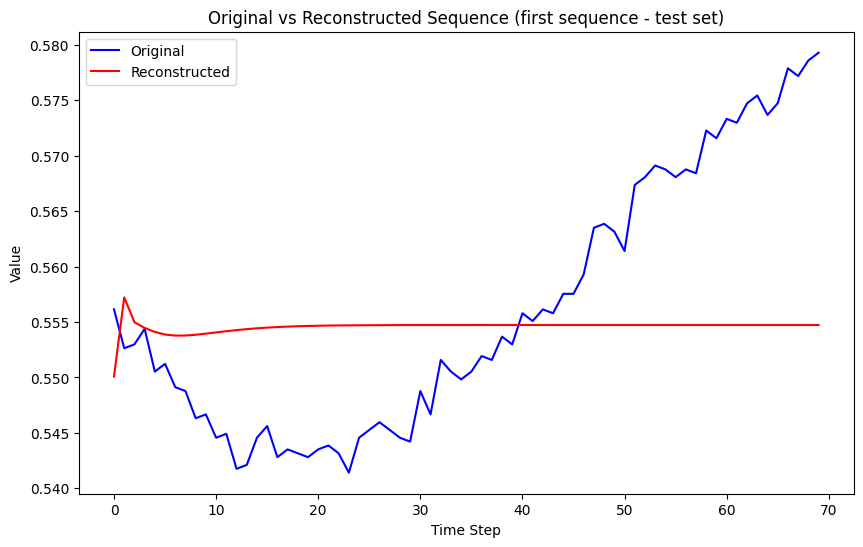

In [ ]:
# Reconstruct sequences using the trained model
reconstructed_sequences_test = model.predict(sequences_ma_test)

# Plot original and reconstructed sequences
plt.figure(figsize=(10, 6))
plt.plot(sequences_ma_test[0], label='Original', color='blue')
plt.plot(reconstructed_sequences_test[0], label='Reconstructed', color='red')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Original vs Reconstructed Sequence (first sequence - test set)')
plt.legend()
plt.show()


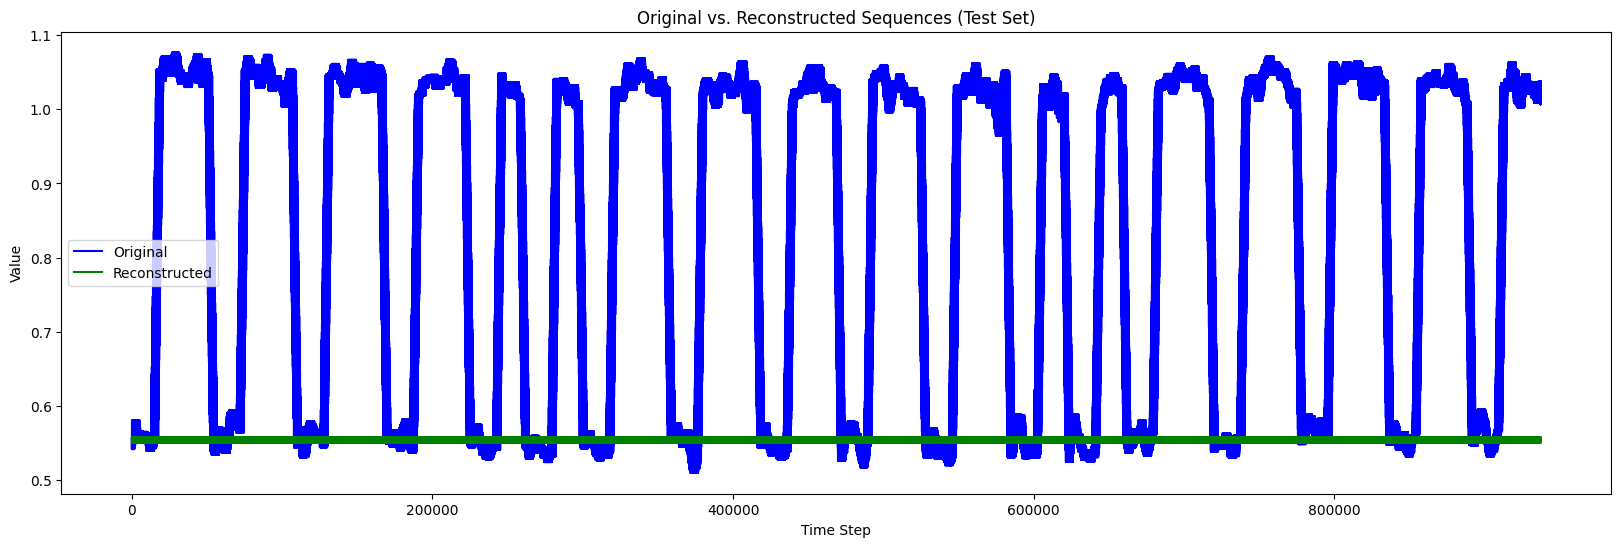

In [ ]:
combined_reconstructed_sequences_test = np.concatenate(reconstructed_sequences_test, axis=0)
combined_sequences_test = np.concatenate(sequences_ma_test, axis=0)

# Plot combined original sequences
plt.figure(figsize=(20, 6))
plt.plot(combined_sequences_test, label='Original', color='blue')
plt.plot(combined_reconstructed_sequences_test, label='Reconstructed', color='green')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Original vs. Reconstructed Sequences (Test Set)')
plt.legend()
plt.show()

/home/ztham/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


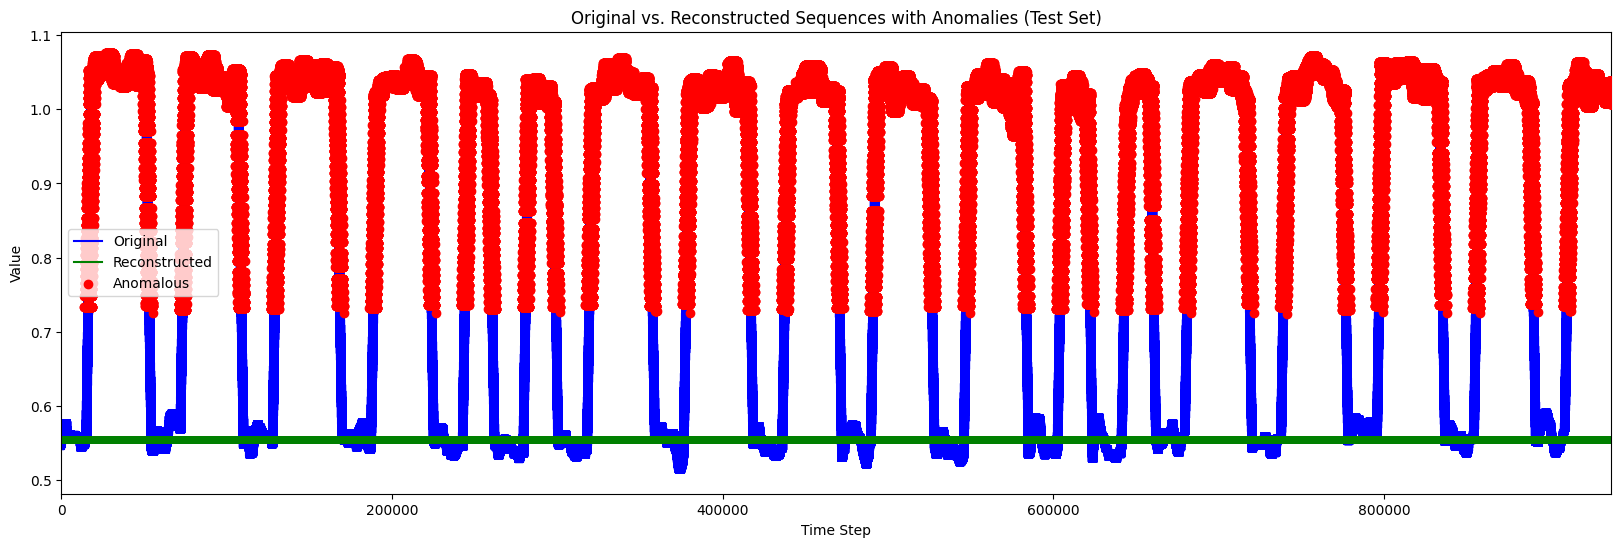

In [ ]:
# Plot combined original sequences
plt.figure(figsize=(20, 6))
plt.plot(combined_sequences_test, label='Original', color='blue', zorder=1)
plt.plot(combined_reconstructed_sequences_test, label='Reconstructed', color='green', zorder=2)

# Mark anomalous data points as red dots
plt.scatter(anomalous_indices, combined_sequences_test[anomalous_indices], color='red', label='Anomalous', zorder=3)

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Original vs. Reconstructed Sequences with Anomalies (Test Set)')
plt.legend()

# Adjust x-axis limits to display more time steps
plt.xlim(0, len(combined_sequences_test))  # Set x-axis limits based on the length of the combined sequences

plt.show()